In [1]:
from python_gdal import *
from models_keras import *
import time
from keras import backend as K

Using TensorFlow backend.


In [2]:
MAIN_FOLDER = r'E:/HSI/'
IP_DATA_PATH = 'IP/Indian_pines_corrected'
IP_TRAIN_PATH = 'IP/Indian_pines_gt'
PAVIA_DATA_PATH = "Pavia/Pavia"
PAVIA_TRAIN_PATH = "Pavia/Pavia_gt"
PAVIA_U_DATA_PATH = "Pavia/PaviaU"
PAVIA_U_TRAIN_PATH = "Pavia/PaviaU_gt"
SALINAS_DATA_PATH = "Salinas/Salinas"
SALINAS_TRAIN_PATH = 'Salinas/Salinas_gt'
KSC_DATA_PATH = "KSC/KSC"
KSC_TRAIN_PATH = "KSC/KSC_gt"
IEEEHSI_2018_DATA_PATH = "2018IEEEHSI/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix"
IEEEHSI_2018_TRAIN_PATH = "2018IEEEHSI/GT"

In [3]:
c = [16, 9, 9, 13]
input_shape1 = [(200,), (102,), (103,), (176,)]
input_shape2 = [(200, 1), (102, 1), (103, 1), (176, 1)]
lists2 = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lists1 = [33, 200, 200, 181, 200, 200, 20, 200, 14, 200, 200, 200, 143, 200, 200, 75]
lists3 = [200, 150, 150, 150, 100, 150, 50, 200, 200, 200, 200, 200, 200]
lists = [lists1, lists2, lists2, lists3]
image_shape = [(145, 145), (1096, 715), (610, 340), (512, 614)]
DATA_PATH = [IP_DATA_PATH, PAVIA_DATA_PATH, PAVIA_U_DATA_PATH, KSC_DATA_PATH]
TRAIN_PATH = [IP_TRAIN_PATH, PAVIA_TRAIN_PATH, PAVIA_U_TRAIN_PATH, KSC_TRAIN_PATH]

In [4]:
i = 2
m = 41

# data prep

In [22]:
train_samples_1, train_labels_1 = get_train_sample(data_path=MAIN_FOLDER+DATA_PATH[i],
                                               train_data_path=MAIN_FOLDER+TRAIN_PATH[i],
                                               c=c[i], m=m, lists=lists[i], d=4)

In [23]:
print(train_samples_1.shape)

(1800, 17, 17, 103)


In [24]:
t = train_samples_1[:, 8, 8, :]
t1= np.expand_dims(t, axis=-1)
print(t1.shape)

(1800, 103, 1)


In [25]:
train_samples_2, train_labels_2 = get_train_sample(data_path=MAIN_FOLDER+DATA_PATH[i],
                                               train_data_path=MAIN_FOLDER+TRAIN_PATH[i],
                                               c=c[i], m=1, lists=lists[i], d=3)

In [26]:
print(train_samples_2.shape)

(1800, 103, 1)


In [27]:
train_labels = one_hot_encode(c=c[i], labels=train_labels_1)

In [28]:
print(train_labels_1[:10])
print(train_labels_2[:10])

[2. 7. 6. 3. 1. 5. 4. 7. 8. 6.]
[2. 7. 6. 3. 1. 5. 4. 7. 8. 6.]


# model prep

In [44]:
input_1 = (200, 1)
input_2 = (17, 17, 200)

In [47]:
def combined_1d_2d(input_1, input_2, c, lr):
    inputs_1 = Input(shape=input_1)
    inputs_2 = Input(shape=input_2)
    x_1 = Conv1D(24, 3, padding='same')(inputs_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)

    x_1 = Conv1D(36, 3, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(3, padding='same')(x_1)
    x_1 = Dropout(rate=0.1)(x_1)

    x_1 = Conv1D(48, 3, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)
    x_1= Dropout(rate=0.1)(x_1)

    x_1 = Conv1D(96, 4, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)
    x_1 = Dropout(rate=0.1)(x_1)

    x_1 = Flatten()(x_1)

    x_2 = Conv2D(12, (3, 3), padding='same')(inputs_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)

    x_2 = Conv2D(24, (3, 3), padding='same')(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)

    x_2 = Conv2D(48, (3, 3), padding='same')(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)
    x_2 = Dropout(rate=0.2)(x_2)

    x_2 = Flatten()(x_2)

    combine_layer = concatenate([x_1, x_2], axis=1)

    y = Dense(256, activation='relu')(combine_layer)

    output = Dense(c, activation='softmax')(y)

    model = Model(inputs=[inputs_1, inputs_2], outputs=output)
    model.compile(optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [48]:
combine_model = combined_1d_2d(input_1, input_2, c=16, lr=0.0001)

In [49]:
combine_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 200, 1)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 200, 24)      96          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 200, 24)      96          conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 200, 24)      0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
max_poolin

In [57]:
print(train_samples_2.shape)

(2466, 200, 1)


In [58]:
train_samples_2 = np.expand_dims(train_samples_1[:, 8, 8, :], axis=-1)

In [59]:
network = combine_model.fit(x=[train_samples_2, train_samples_1],
                            y = train_labels, epochs=20, verbose=1)

Epoch 1/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.1086 - acc: 0.9688
Epoch 2/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0632 - acc: 0.9878
Epoch 3/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0950 - acc: 0.9708
Epoch 4/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0573 - acc: 0.9886
Epoch 5/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0571 - acc: 0.9866A: 1s - loss
Epoch 6/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0494 - acc: 0.9891
Epoch 7/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0512 - acc: 0.9874
Epoch 8/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.1056 - acc: 0.9639
Epoch 9/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0429 - acc: 0.9915
Epoch 10/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0785 - acc: 0.9765
Epoch 11/20
2466/

In [60]:
save_model(combine_model, "cnn_1d_2d_17.h5")

In [63]:
def get_test_predict(model, data_path, train_data_path, c, lists, bsize, norma_methods='z-score', pca=False, m=1, n=3):
    bands_data, is_train, training_labels = get_prep_data(data_path, train_data_path,
                                                          norma_method=norma_methods,
                                                          pca=pca, n=n)
    _, x_test_index, _, y_test = custom_train_index(is_train, training_labels, c=c, lists=lists)
    samples = []
    predicts = []
    if m == 1:
        for i in x_test_index:
            sample = bands_data[i[0], i[1]]
            samples.append(sample)
        samples = np.stack(samples)
        if len(model.input.shape) == 3:
            samples = samples.reshape((samples.shape[0], samples.shape[1], -1))
        predicts = model.predict(samples)

    else:
        n = int((m - 1) / 2)
        x_test_nindex = x_test_index + n
        bands_data = np.pad(bands_data, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
        for i, j in enumerate(x_test_nindex):
            k1 = j[0] - n
            k2 = j[0] + n + 1
            k3 = j[1] - n
            k4 = j[1] + n + 1
            block = bands_data[k1:k2, k3:k4]
            samples.append(block)
            if len(samples) == bsize or i == x_test_nindex.shape[0] - 1:
                # print("Batches Predictions...")
                pre = np.stack(samples)
#                 if len(model.input.shape) == 5:
#                     pre = pre.reshape((pre.shape[0], pre.shape[1], pre.shape[2], pre.shape[3], -1))
                pre1 = np.expand_dims(pre[:, n, n, :], axis=-1) 
                predict = model.predict([pre1, pre])
                predicts.append(predict)
                samples = []
        predicts = np.concatenate(predicts)
    print("Batches Predictions Finish!!!")
    OA, KAPPA = print_plot_cm(y_test, predicts)
    return OA, KAPPA

In [64]:
OA, KAPPA = get_test_predict(model=combine_model, data_path=MAIN_FOLDER+DATA_PATH[i],
                             train_data_path=MAIN_FOLDER+TRAIN_PATH[i], c=16,
                             lists=lists[i], bsize=3200, norma_methods='z-score',m=17)

Batches Predictions Finish!!!


In [65]:
print(OA, KAPPA)

0.9614544520107927 0.9546723210077922


# features prep

In [15]:
cnn_1d_path = r"e:/HSI/code/new_model_0/"
cnn_2d_path = r"e:/HSI/code/new_model_2/"

In [17]:
cnn_1d_model = load_model(cnn_1d_path + "cnn_1d_P.h5")
cnn_2d_model = load_model(cnn_2d_path + "41-cnn_2d_P.h5")

In [18]:
cnn_1d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 102, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 102, 12)           72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 102, 12)           48        
_________________________________________________________________
activation_1 (Activation)    (None, 102, 12)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 12)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 24)            1464      
_________________________________________________________________
batch_normalization_2 (Batch (None, 51, 24)            96        
__________

In [19]:
cnn_2d_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_154 (InputLayer)       (None, 41, 41, 102)       0         
_________________________________________________________________
conv2d_460 (Conv2D)          (None, 41, 41, 12)        11028     
_________________________________________________________________
batch_normalization_460 (Bat (None, 41, 41, 12)        48        
_________________________________________________________________
activation_460 (Activation)  (None, 41, 41, 12)        0         
_________________________________________________________________
max_pooling2d_460 (MaxPoolin (None, 21, 21, 12)        0         
_________________________________________________________________
conv2d_461 (Conv2D)          (None, 21, 21, 24)        2616      
_________________________________________________________________
batch_normalization_461 (Bat (None, 21, 21, 24)        96        
__________

In [31]:
cnn_1d_feature = K.function([cnn_1d_model.layers[0].input, K.learning_phase()],
                            [cnn_1d_model.layers[-4].output])

In [32]:
cnn_2d_feature = K.function([cnn_2d_model.layers[0].input, K.learning_phase()],
                            [cnn_2d_model.layers[-4].output])

In [33]:
features_1d = cnn_1d_feature([train_samples_2])[0]

In [34]:
features_2d = cnn_2d_feature([train_samples_1])[0]

In [35]:
print(features_1d.shape)
print(features_2d.shape)

(1800, 624)
(1800, 432)


# features concatenate

In [36]:
fusion_layer = np.concatenate([features_1d, features_2d], axis=1)

In [37]:
print(fusion_layer.shape)

(1800, 1056)


In [42]:
inputs = Input(shape=(fusion_layer.shape[-1],))
y = Dense(128, activation='relu')(inputs)
y = Dense(128, activation='relu')(y)
output = Dense(c[i], activation='softmax')(y)

In [43]:
model1 = Model(inputs=inputs, outputs=output)

In [44]:
model1.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [45]:
network = model1.fit(fusion_layer, train_labels, batch_size=50, epochs=50, verbose=1)

Epoch 1/50
1800/1800 [==============================] - 2s 919us/step - loss: 1.6023 - acc: 0.5717
Epoch 2/50
1800/1800 [==============================] - 0s 68us/step - loss: 0.7929 - acc: 0.9106
Epoch 3/50
1800/1800 [==============================] - 0s 68us/step - loss: 0.4171 - acc: 0.9683
Epoch 4/50
1800/1800 [==============================] - 0s 68us/step - loss: 0.2452 - acc: 0.9839
Epoch 5/50
1800/1800 [==============================] - 0s 69us/step - loss: 0.1583 - acc: 0.9883
Epoch 6/50
1800/1800 [==============================] - 0s 70us/step - loss: 0.1099 - acc: 0.9922
Epoch 7/50
1800/1800 [==============================] - 0s 70us/step - loss: 0.0812 - acc: 0.9933
Epoch 8/50
1800/1800 [==============================] - 0s 69us/step - loss: 0.0630 - acc: 0.9950
Epoch 9/50
1800/1800 [==============================] - 0s 69us/step - loss: 0.0498 - acc: 0.9956
Epoch 10/50
1800/1800 [==============================] - 0s 69us/step - loss: 0.0399 - acc: 0.9961
Epoch 11/50
1800/1

In [46]:
predic = model.predict(fusion_layer)
print_plot_cm(train_labels, predic)

NameError: name 'model' is not defined

In [47]:
bands_data, is_train, training_labels = get_prep_data(data_path=MAIN_FOLDER+DATA_PATH[i], 
                                                      train_data_path=MAIN_FOLDER+TRAIN_PATH[i])

In [48]:
_, x_test_index, _, y_test = custom_train_index(is_train, training_labels, c=c[i], 
                                                lists=lists[i])

In [49]:
samples = []
for j in x_test_index:
    sample = bands_data[j[0], j[1]]
    samples.append(sample)
samples = np.stack(samples)
samples = samples.reshape((samples.shape[0], samples.shape[1], -1))

In [50]:
print(samples.shape)

(40976, 103, 1)


In [51]:
featurs_1 = cnn_1d_feature([samples])[0]

In [52]:
print(featurs_1.shape)

(40976, 624)


In [53]:
samples_1 = []
features = []
n = int((m - 1) / 2)
x_test_nindex = x_test_index + n
bands_data = np.pad(bands_data, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
for i, j in enumerate(x_test_nindex):
    k1 = j[0] - n
    k2 = j[0] + n + 1
    k3 = j[1] - n
    k4 = j[1] + n + 1
    block = bands_data[k1:k2, k3:k4]
    samples_1.append(block)
    if len(samples_1) == 3200 or i == x_test_nindex.shape[0] - 1:
        print("Batches Features...")
        pre = np.stack(samples_1)
        feature = cnn_2d_feature([pre])[0]
        features.append(feature)
        samples_1 = []
features = np.concatenate(features)

Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...


In [54]:
print(features.shape)

(40976, 432)


In [55]:
fea = np.concatenate([featurs_1, features], axis=1)
print(fea.shape)

(40976, 1056)


In [56]:
pred = model1.predict(fea)

              precision    recall  f1-score   support

         1.0     0.9984    0.9784    0.9883      6431
         2.0     0.9992    0.9966    0.9979     18449
         3.0     0.9968    0.9979    0.9974      1899
         4.0     0.9882    0.9937    0.9909      2864
         5.0     1.0000    1.0000    1.0000      1145
         6.0     0.9930    0.9996    0.9963      4829
         7.0     0.9560    0.9991    0.9771      1130
         8.0     0.9747    0.9957    0.9851      3482
         9.0     0.9987    1.0000    0.9993       747

   micro avg     0.9941    0.9941    0.9941     40976
   macro avg     0.9894    0.9957    0.9925     40976
weighted avg     0.9942    0.9941    0.9941     40976



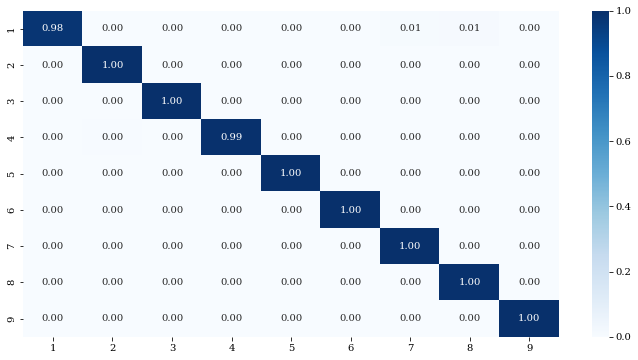

(0.9941185083951581, 0.9920878164547403)

In [57]:
print_plot_cm(y_test, pred)

In [59]:
bands_data_dict = sio.loadmat(MAIN_FOLDER+DATA_PATH[2])
bands_data_1 = bands_data_dict[list(bands_data_dict.keys())[-1]]
bands_data_1 = norma_data(bands_data_1)

In [60]:
print(MAIN_FOLDER+DATA_PATH[2])

E:/HSI/Pavia/PaviaU


In [61]:
pre = bands_data_1.reshape((bands_data_1.shape[0]*bands_data_1.shape[1], bands_data_1.shape[2], -1))

In [62]:
print(pre.shape)

(207400, 103, 1)


In [63]:
f1 = cnn_1d_feature([pre])[0]

In [64]:
print(f1.shape)

(207400, 624)


In [65]:
print(bands_data_1.shape)

(610, 340, 103)


In [66]:
n = int((m - 1) / 2)
bands_data_1 = np.pad(bands_data_1, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
cols = bands_data_1.shape[1]-2*n
rows = bands_data_1.shape[0]-2*n
result1 = []
f2 = []
for g in range(0, rows, 1):
    for h in range(0, cols, 1):
        data = bands_data_1[g: g + m, h: h + m, :]
        result1.append(data)
        if len(result1) == 3200 or g == int(rows-1):
            print("Batches Features...")
            pre1 = np.stack(result1)
            fe = cnn_2d_feature([pre1])[0]
            f2.append(fe)
            result1 = []
f2 = np.concatenate(f2)

Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...


In [67]:
print(f2.shape)

(207400, 432)


In [68]:
f3 = np.concatenate([f1, f2], axis=1)

In [69]:
p = model1.predict(f3)

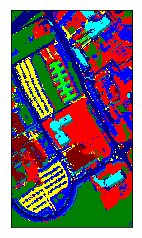

In [71]:
write_whole_image_classification_result(p, shape=(610, 340))



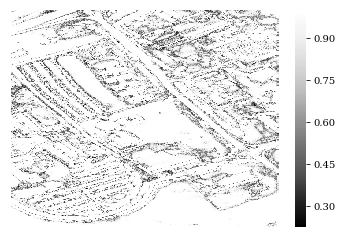

In [72]:
write_whole_image_predicts_prob(p, shape=(610, 340))

0.03688042430086789


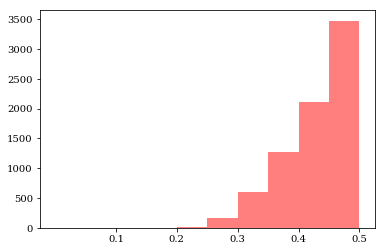

In [73]:
cof = write_whole_image_predicts_prob1(p, shape=(610, 340))
print(cof)